In [1]:
from tensorflow import keras
keras.__version__

'2.2.4-tf'

# Sequence processing with convnets

This notebook contains the code samples found in Chapter 6, Section 4 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

<img src="https://github.com/soo-pecialist/Deep_Learning_with_Python/blob/master/imgages/Figure6_26.png?raw=true" alt="Figure 6-26" width=500>


## Implementing a 1D convnet

In Keras, you would use a 1D convnet via the `Conv1D` layer, which has a very similar interface to `Conv2D`. It takes as input 3D tensors 
with shape `(samples, time, features)` and also returns similarly-shaped 3D tensors. The convolution window is a 1D window on the temporal 
axis, axis 1 in the input tensor.

Let's build a simple 2-layer 1D convnet and apply it to the IMDB sentiment classification task that you are already familiar with.

As a reminder, this is the code for obtaining and preprocessing the data:

In [2]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10_000  # number of words to consider as features
max_len = 500  # cut texts after this number of words (among top max_features most common words)

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


In [3]:
# x_train[1]


1D convnets are structured in the same way as their 2D counter-parts that you have used in Chapter 5: they consist of a stack of `Conv1D` 
and `MaxPooling1D` layers, eventually ending in either a global pooling layer or a `Flatten` layer, turning the 3D outputs into 2D outputs, 
allowing to add one or more `Dense` layers to the model, for classification or regression.

One difference, though, is the fact that we can afford to use larger convolution windows with 1D convnets. Indeed, with a 2D convolution 
layer, a 3x3 convolution window contains 3*3 = 9 feature vectors, but with a 1D convolution layer, a convolution window of size 3 would 
only contain 3 feature vectors. We can thus easily afford 1D convolution windows of size 7 or 9.

This is our example 1D convnet for the IMDB dataset:

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
______________________________________________

Here are our training and validation results: validation accuracy is somewhat lower than that of the LSTM we used two sections ago, but 
runtime is faster, both on CPU and GPU (albeit the exact speedup will vary greatly depending on your exact configuration). At that point, 
we could re-train this model for the right number of epochs (8), and run it on the test set. This is a convincing demonstration that a 1D 
convnet can offer a fast, cheap alternative to a recurrent network on a word-level sentiment classification task.

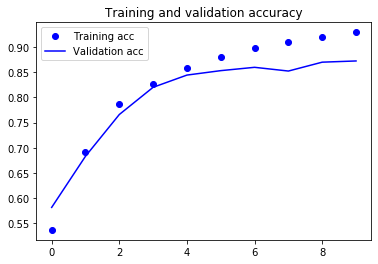

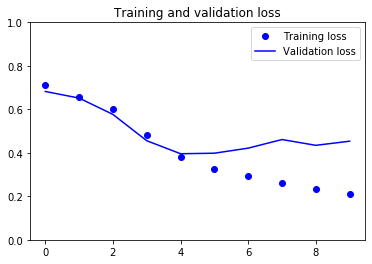

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylim(0.0, 1.0)
plt.legend()

plt.show()

## Combining CNNs and RNNs to process long sequences


Because 1D convnets process input patches independently, they are not sensitive to the order of the timesteps (beyond a local scale, the 
size of the convolution windows), unlike RNNs. Of course, in order to be able to recognize longer-term patterns, one could stack many 
convolution layers and pooling layers, resulting in upper layers that would "see" long chunks of the original inputs -- but that's still a 
fairly weak way to induce order-sensitivity. **One way to evidence this weakness** is to try 1D convnets on the temperature forecasting problem 
from the previous section, where order-sensitivity was key to produce good predictions. Let's see:

#### Case of 1d convnet not working great

In [6]:
# We reuse the following variables defined in the last section:
# float_data, train_gen, val_gen, val_steps

import os
import numpy as np


data_dir = '/Users/soohyeonkim/GoogleDrive/Coding/DeepLearning/DLwPy/inplay'
fname = os.path.join(data_dir, 'data/download/jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    
    ### we want [-23h, -22h, ..., now] (24 hr) range. that's why we set index accordingly. 
    ### keep in mind we use range(min_index, max_index) which gives [min_index, max_index) range
    ### to match our time range goal, we need to be careful.
    
    if max_index is None: # use all datay
        max_index = len(data) - delay # we include current time 
    min_index += 1 # we want data since 24 hr ago 
    i = min_index + lookback
    
    
    while 1: # infinite loop
        if shuffle:
            row_idxs = np.random.randint(
                min_index + lookback, max_index, size=batch_size) # +1 because range is [a, b)
        else:
            if i + batch_size >= max_index: # if overflow, reset to the origin
                i = min_index + lookback
            row_idxs = np.arange(i, min(i + batch_size, max_index)) # same reason
            i += len(row_idxs)

        samples = np.zeros((len(row_idxs), # batch size
                           lookback // step, # sample every hour (60 min)
                           data.shape[-1])) # take all attributes
        targets = np.zeros((len(row_idxs),)) # batch size
        
        for j, row in enumerate(row_idxs): # get indexes of current batch and global batch
            indices = range(row - lookback, row, step) # global indexs: 
                                                           # [current-lookback, current-lookback+1hr, ...  current]
            samples[j] = data[indices] # ((lookback//step), # features)
            targets[j] = data[row + delay][1] # temperature in 24 hours from "now"
        yield samples, targets
        
lookback = 1_440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, # original sequence data
                      lookback=lookback, # how far reference goes back 
                      delay=delay, # where to look in the future
                      min_index=0, # start 
                      max_index=200_000, # end #first 200_000 time steps
                      shuffle=True, # shuffle : True
                      step=step, # get referece every step time
                      batch_size=batch_size)

# note that no shuffling for validation and test data
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200_001,
                    max_index=300_000, # next 100_000 time steps
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300_001,
                     max_index=None, # look at the remainder
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300_000 - 200_001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300_001 - lookback) // batch_size

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 40s 79ms/step - loss: 0.4173 - val_loss: 0.4325
Epoch 2/20
500/500 [==============================] - 39s 77ms/step - loss: 0.3637 - val_loss: 0.4427
Epoch 3/20
500/500 [==============================] - 50s 100ms/step - loss: 0.3413 - val_loss: 0.4668
Epoch 4/20
500/500 [==============================] - 46s 92ms/step - loss: 0.3241 - val_loss: 0.4353
Epoch 5/20
500/500 [==============================] - 45s 91ms/step - loss: 0.3136 - val_loss: 0.4774
Epoch 6/20
500/500 [==============================] - 42s 84ms/step - loss: 0.3059 - val_loss: 0.4534
Epoch 7/20
500/500 [==============================] - 44s 87ms/step - loss: 0.2968 - val_loss: 0.4537
Epoch 8/20
500/500 [==============================] - 42s 84ms/step - loss: 0.2907 - val_loss: 0.4828
Epoch 9/20
500/500 [==============================] - 44s 88ms/step - loss: 0.2844 - val_loss: 0.4873
Epoch 10/20
500/500 [==============================] - 44s 87ms/step - loss: 0.28

Here are our training and validation Mean Absolute Errors:

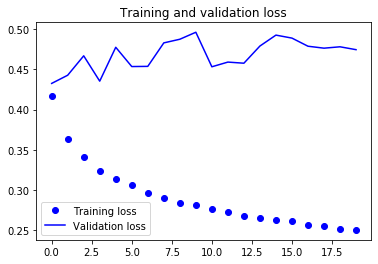

In [8]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


The validation MAE stays in the low 0.40s: we cannot even beat our common-sense baseline using the small convnet. Again, this is because 
our convnet looks for patterns anywhere in the input timeseries, and has no knowledge of the temporal position of a pattern it sees (e.g. 
towards the beginning, towards the end, etc.). Since more recent datapoints should be interpreted differently from older datapoints in the 
case of this specific forecasting problem, the convnet fails at producing meaningful results here. This limitation of convnets was not an 
issue on IMDB, because patterns of keywords that are associated with a positive or a negative sentiment will be informative independently 
of where they are found in the input sentences.

One strategy to combine the speed and lightness of convnets with the order-sensitivity of RNNs is to use a 1D convnet as a preprocessing 
step before a RNN. This is especially beneficial when dealing with sequences that are so long that they couldn't realistically be processed 
with RNNs, e.g. sequences with thousands of steps. The convnet will turn the long input sequence into much shorter (downsampled) sequences 
of higher-level features. This sequence of extracted features then becomes the input to the RNN part of the network.

<img src="https://github.com/soo-pecialist/Deep_Learning_with_Python/blob/master/imgages/Figure6_30.png?raw=true" alt="Figure 6-30" width=500>



This technique is not seen very often in research papers and practical applications, possibly because it is not very well known. **It is very effective and ought to be more common**. Let's try this out on the temperature forecasting dataset. Because this strategy allows us to 
manipulate much longer sequences, we could either look at data from further back (by increasing the `lookback` parameter of the data 
generator), or look at high-resolution timeseries (by decreasing the `step` parameter of the generator). Here, we will chose (somewhat 
arbitrarily) to use a **`step` twice smaller, resulting in twice longer timeseries, where the weather data is being sampled at a rate of one point per 30 minutes**.

In [9]:
# This was previously set to 6 (one point per hour).
# Now 3 (one point per 30 min).
step = 3 # changed from 6
lookback = 720  # changed: 10 days (1440) -> 5 days
delay = 144 # Unchanged: 24 hrs later
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200_000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200_001,
                    max_index=300_000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300_001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)
val_steps = (300_000 - 200_001 - lookback) // batch_size
test_steps = (len(float_data) - 300_001 - lookback) // batch_size

This is our model, starting with two `Conv1D` layers and following-up with a `GRU` layer:

In [10]:
lookback//step

480

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500, # 500 * 128
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 481s 962ms/step - loss: nan - val_loss: nan
Epoch 2/20
430/500

KeyboardInterrupt: 

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Judging from the validation loss, this setup is not quite as good as the regularized GRU alone, but it's significantly faster. It is 
looking at twice more data, which in this case doesn't appear to be hugely helpful, but may be important for other datasets.

## Wrapping up

Here's what you should take away from this section:

* In the same way that 2D convnets perform well for processing visual patterns in 2D space, 1D convnets perform well for processing 
temporal patterns. They offer a faster alternative to RNNs on some problems, in particular NLP tasks.
* Typically 1D convnets are structured much like their 2D equivalents from the world of computer vision: they consist of stacks of `Conv1D` 
layers and `MaxPooling1D` layers, eventually ending in a global pooling operation or flattening operation.
* Because RNNs are extremely expensive for processing very long sequences, but 1D convnets are cheap, it can be a good idea to use a 1D 
convnet as a preprocessing step before a RNN, shortening the sequence and extracting useful representations for the RNN to process.

One useful and important concept that we will not cover in these pages is that of 1D convolution with dilated kernels.